In [1]:
!pip3 -qq install torch==0.4.1
!pip install -qq bokeh==0.13.0
!wget -O surnames.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1ji7dhr9FojPeV51dDlKRERIqr3vdZfhu"

tcmalloc: large alloc 1073750016 bytes == 0x59214000 @  0x7f15eb3522a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети

## Классификация фамилий

Теперь - по языкам:

In [3]:
data, labels = [], []
with open('surnames.txt') as f:
    for line in f:
        surname, lang = line.strip().split('\t')
        data.append(surname)
        labels.append(lang)

for i in np.random.randint(0, len(data), 10):
    print(data[i], labels[i])

Mikhnev Russian
Morcos Arabic
Morrow English
Berezinsky Russian
Badyaev Russian
Teale English
Prigorodov Russian
Greening English
Jankevich Russian
Bahin Russian


### Разминка

Проверьте свои знания - попробуйте самостоятельно предсказать, к какому языку относится фамилия :)

In [0]:
from sklearn.utils.class_weight import compute_class_weight

def test_generator():
    classes = np.unique(labels)
    weights = compute_class_weight('balanced', classes, labels)
    classes = {label: ind for ind, label in enumerate(classes)}

    probs = np.array([weights[classes[label]] for label in labels])
    probs /= probs.sum()

    ind = np.random.choice(np.arange(len(data)), p=probs)
    yield data[ind]
    
    while True:
        new_ind = np.random.choice(np.arange(len(data)), p=probs)
        yield labels[ind], data[new_ind]
        ind = new_ind
        
gen = test_generator()
question = next(gen)

Запускайте, смотрите на фамилию, которая выведется - и выбирайте язык в выпадающем списке.

In [6]:
#@title Проверим себя (или адекватность данных) { run: "auto" }
answer = "Korean" #@param ["Arabic", "Chinese", "Czech", "Dutch", "English", "French", "German", "Greek", "Irish", "Italian", "Japanese", "Korean", "Polish", "Portuguese", "Russian", "Scottish", "Spanish", "Vietnamese"]

correct_answer, question = next(gen)

if 'correct_count' not in globals():
    correct_count = 0
    total_count = 0
else:
    if answer == correct_answer:
        print('You are correct', end=' ')
        correct_count += 1
    else:
        print("No, it's", correct_answer, end=' ')

    total_count += 1
    print('({} / {})'.format(correct_count, total_count))
    
print('Next surname:', question)

You are correct (1 / 1)
Next surname: Bao


### Разбиение данных

Для начала нужно построить сплит данных на трейн/тест. Сложность в том, что классы распределены неравномерны, а отрезать нужно от каждого класса пропорциональное количество данных на тест. Для этого нужно использовать `stratify` параметр функции `train_test_split` (либо `StratifiedShuffleSplit`, либо, при большом желании, `GroupShuffleSplit`).

In [0]:
from sklearn.model_selection import train_test_split

data_train, data_test, labels_train, labels_test = train_test_split(
    data, labels, test_size=0.3, stratify=labels, random_state=42
)

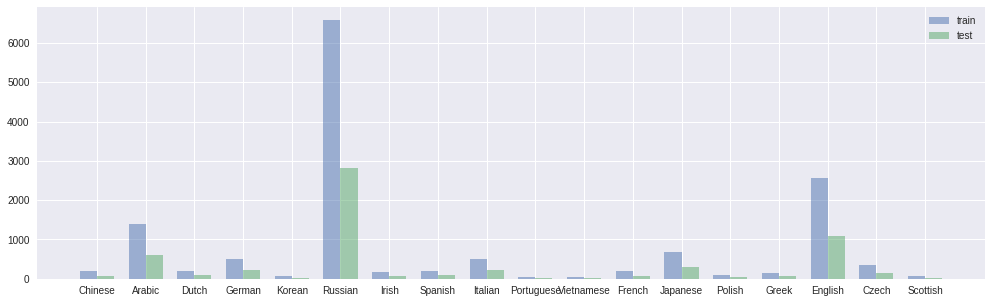

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

langs = set(labels)

train_distribution = Counter(labels_train)
train_distribution = [train_distribution[lang] for lang in langs]

test_distribution = Counter(labels_test)
test_distribution = [test_distribution[lang] for lang in langs]

plt.figure(figsize=(17, 5))

bar_width = 0.35
plt.bar(np.arange(len(langs)), train_distribution, bar_width, align='center', alpha=0.5, label='train')
plt.bar(np.arange(len(langs)) + bar_width, test_distribution, bar_width, align='center', alpha=0.5, label='test')
plt.xticks(np.arange(len(langs)) + bar_width / 2, langs)
plt.legend()
    
plt.show()

### Бейзлайн

Всегда надо начинать с бейзлайна - воспользуемся нашей любимой парой vectorizer-logistic regression:

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='char', ngram_range=(1, 4))),
    ('log_regression', LogisticRegression())
])

model.fit(data_train, labels_train)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 4), preprocessor=None, stop_words=None,
       ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

Какие метрики будем считать? Тут многоклассовая классификация, поэтому всё очень неоднозначно.

Имеет смысл посмотреть на accuracy и на F1-score'ы для каждого класса.

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

preds = model.predict(data_test)

print('Accuracy = {:.2%}'.format(accuracy_score(labels_test, preds)))
print('Classification report:')
print(classification_report(labels_test, preds))

Accuracy = 83.45%
Classification report:
             precision    recall  f1-score   support

     Arabic       0.90      1.00      0.95       600
    Chinese       0.65      0.57      0.61        80
      Czech       0.58      0.28      0.38       156
      Dutch       0.85      0.49      0.62        89
    English       0.72      0.84      0.78      1101
     French       0.52      0.19      0.28        83
     German       0.61      0.51      0.55       217
      Greek       0.93      0.64      0.76        61
      Irish       0.65      0.44      0.53        70
    Italian       0.74      0.72      0.73       213
   Japanese       0.91      0.90      0.90       297
     Korean       0.25      0.14      0.18        28
     Polish       0.61      0.33      0.43        42
 Portuguese       0.27      0.14      0.18        22
    Russian       0.92      0.96      0.94      2823
   Scottish       0.00      0.00      0.00        30
    Spanish       0.48      0.28      0.35        89
 Vie

F1-score'ы можно агрегировать разными способами:
- weighted - это как посчитал classification_report - если нам важнее предсказывать хорошо более частотные фамилии
- macro - простое усреднение - если важно предсказывать все, независимо от того, сколько каждого класса в тестовой выборке
- micro - обычный подсчет F1-score по суммам всех true positive, false positive и false negative

Weighted и micro - две метрики, учитывающие дисбаланс классов. Но в нашем случае неочевидно, есть ли дисбаланс, да?

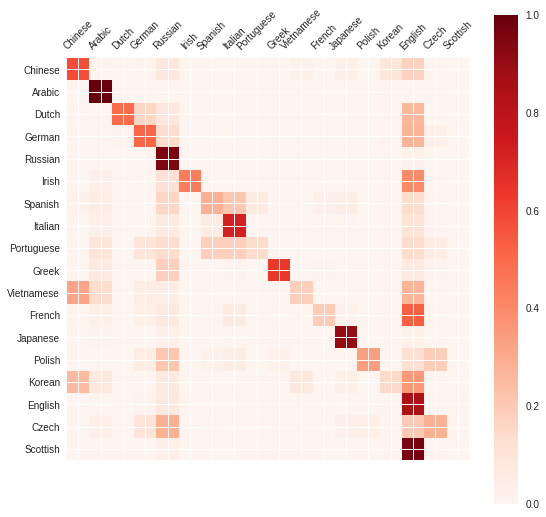

In [11]:
import matplotlib.ticker as ticker

label_names = list(set(labels_test))
confusion = confusion_matrix(labels_test, preds, labels=label_names).astype(np.float)
confusion /= confusion.sum(axis=-1, keepdims=True)

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion, cmap='Reds')
fig.colorbar(cax)

ax.set_xticklabels([''] + label_names, rotation=45)
ax.set_yticklabels([''] + label_names)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## Simple RNN

Основная прелесть RNN - расшаренные параметры. Посмотрите на картинку:

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg =x250)

*From [(The Unreasonable Effectiveness of Recurrent Neural Networks)](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Первый пример - это обычная полносвязная сеть. Каждый следующий демонстрирует обработку некоторой последовательности произвольной длины (красные прямоугольнички) и генерацию выходной последовательности, также произвольной длины (синие прямоугольники).

При этом зеленые прямоугольники в каждом рисунке - это одни и те же веса. Получается, мы, с одной стороны, обучаем очень-очень глубокую сеть (если посмотреть на неё перевернутую), а с другой - строго ограниченное количество параметров.

---
Напишем сразу простую RNN!

Напомню, делает она примерно вот это:

![rnn-unrolled](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png =x220)

*From [(Understanding LSTM Networks)](http://colah.github.io/posts/2015-08-Understanding-LSTMs)*

Вообще говоря, можно придумать много вариаций на тему такой реализации. В нашем случае, обработка будет такой:
$$h_t = tanh(W_h [h_{t-1}; x_t] + b_h)$$

$h_{t-1}$ - скрытое состояние, полученное на предыдущем шаге, $x_t$ - входной вектор. $[h_{t-1}; x_t]$ - простая конкатенация векторов. Всё как на картинке!

Проверим нашу сеть на очень простой задаче: заставим её говорить индекс первого элемента в последовательности.

Т.е. для последовательности `[1, 2, 1, 3]` сеть должна предсказывать `1`.

Начнем с генерации батча.

In [12]:
def generate_data(batch_size=128, seq_len=5):
    data = torch.randint(0, 10, size=(seq_len, batch_size), dtype=torch.long)
    return data, data[0]

X_val, y_val = generate_data(16, 5)
X_val, y_val

(tensor([[1, 2, 6, 7, 8, 4, 4, 7, 8, 3, 5, 8, 0, 1, 6, 3],
         [4, 1, 4, 2, 5, 2, 8, 9, 8, 0, 1, 1, 4, 0, 1, 7],
         [2, 5, 9, 2, 5, 0, 4, 1, 9, 4, 4, 3, 4, 7, 5, 1],
         [8, 9, 9, 2, 7, 9, 3, 4, 2, 5, 8, 3, 6, 8, 1, 5],
         [2, 4, 3, 4, 1, 6, 9, 7, 3, 6, 7, 0, 2, 7, 6, 3]]),
 tensor([1, 2, 6, 7, 8, 4, 4, 7, 8, 3, 5, 8, 0, 1, 6, 3]))

Обратите внимание, что батч имеет размерность `(sequence_length, batch_size, input_size)`. Все `RNN` в pytorch работают с таким форматом по умолчанию.

Сделано это из соображений производительности, но при желании можно поменять такое поведение с помощью аргумента `batch_first`.

**Задание** Реализуйте класс `SimpleRNN`, выполняющий рассчеты по формуле выше.

In [0]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self._hidden_size = hidden_size
        self._hidden = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, inputs, hidden=None):
        seq_len, batch_size = inputs.shape[:2]
        
        if hidden is None:
            hidden = inputs.new_zeros(batch_size, self._hidden_size)
         
        for i in range(len(inputs)):
            hidden = torch.tanh(self._hidden(torch.cat((hidden, inputs[i]), -1)))

        return hidden

**Задание** Реализуйте класс `MemorizerModel`, с последовательностью операций `Embedding -> SimpleRNN -> Linear`. Можно использовать `nn.Sequential`

Чтобы сделать эмбеддинги, можно воспользоваться `nn.Embedding.from_pretrained`. Для простоты будем делать one-hot-encoding представление - для этого нужно просто инициализировать сеть единичной матрицей `torch.eye(N)`.

In [0]:
rnn = nn.Sequential(
    nn.Embedding.from_pretrained(torch.eye(10)),
    SimpleRNN(10, 32),
    nn.Linear(32, 10)
)

Запустим обучение:

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters())

total_loss = 0
epochs_count = 1000
for epoch_ind in range(epochs_count):
    X_train, y_train = generate_data(seq_len=5)
    
    optimizer.zero_grad()
    rnn.train()
    
    logits = rnn(X_train)

    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()
    
    if (epoch_ind + 1) % 100 == 0:
        rnn.eval()
        
        with torch.no_grad():
            logits = rnn(X_val)
            val_loss = criterion(logits, y_val)
            print('[{}/{}] Train: {:.3f} Val: {:.3f}'.format(epoch_ind + 1, epochs_count, 
                                                             total_loss / 100, val_loss.item()))
            total_loss = 0

[100/1000] Train: 2.085 Val: 1.598
[200/1000] Train: 1.030 Val: 0.651
[300/1000] Train: 0.331 Val: 0.150
[400/1000] Train: 0.094 Val: 0.063
[500/1000] Train: 0.048 Val: 0.037
[600/1000] Train: 0.030 Val: 0.025
[700/1000] Train: 0.021 Val: 0.018
[800/1000] Train: 0.016 Val: 0.014
[900/1000] Train: 0.013 Val: 0.011
[1000/1000] Train: 0.010 Val: 0.009


**Задание** Посмотрите на то, как влияет длина последовательности на работу сети. 

Во-первых, посмотрите, с какой длиной сеть в состоянии учиться. Во-вторых, попробуйте обучить сеть с небольшой длиной последовательности, а потом применять её к более длинным.

In [16]:
rnn = nn.Sequential(
    nn.Embedding.from_pretrained(torch.eye(10)),
    SimpleRNN(10, 32),
    nn.Linear(32, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters())

total_loss = 0
epochs_count = 1000
for epoch_ind in range(epochs_count):
    X_train, y_train = generate_data(seq_len=7)
    
    optimizer.zero_grad()
    rnn.train()
    
    logits = rnn(X_train)

    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()
    
    if (epoch_ind + 1) % 100 == 0:
        rnn.eval()
        
        with torch.no_grad():
            logits = rnn(X_val)
            val_loss = criterion(logits, y_val)
            print('[{}/{}] Train: {:.3f} Val: {:.3f}'.format(epoch_ind + 1, epochs_count, 
                                                             total_loss / 100, val_loss.item()))
            total_loss = 0

[100/1000] Train: 2.302 Val: 2.300
[200/1000] Train: 1.645 Val: 2.783
[300/1000] Train: 0.543 Val: 4.094
[400/1000] Train: 0.172 Val: 5.404
[500/1000] Train: 0.063 Val: 6.134
[600/1000] Train: 0.035 Val: 6.631
[700/1000] Train: 0.024 Val: 7.019
[800/1000] Train: 0.017 Val: 7.333
[900/1000] Train: 0.013 Val: 7.577
[1000/1000] Train: 0.010 Val: 7.729


In [17]:
rnn = nn.Sequential(
    nn.Embedding.from_pretrained(torch.eye(10)),
    SimpleRNN(10, 32),
    nn.Linear(32, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters())

total_loss = 0
epochs_count = 1000
for epoch_ind in range(epochs_count):
    X_train, y_train = generate_data(seq_len=10)
    
    optimizer.zero_grad()
    rnn.train()
    
    logits = rnn(X_train)

    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()
    
    if (epoch_ind + 1) % 100 == 0:
        rnn.eval()
        
        with torch.no_grad():
            logits = rnn(X_val)
            val_loss = criterion(logits, y_val)
            print('[{}/{}] Train: {:.3f} Val: {:.3f}'.format(epoch_ind + 1, epochs_count, 
                                                             total_loss / 100, val_loss.item()))
            total_loss = 0

[100/1000] Train: 2.306 Val: 2.302
[200/1000] Train: 2.303 Val: 2.311
[300/1000] Train: 2.278 Val: 2.660
[400/1000] Train: 1.033 Val: 9.046
[500/1000] Train: 0.458 Val: 10.939
[600/1000] Train: 0.181 Val: 12.019
[700/1000] Train: 0.089 Val: 12.571
[800/1000] Train: 0.065 Val: 13.118
[900/1000] Train: 0.039 Val: 13.402
[1000/1000] Train: 0.046 Val: 13.606


**Задание** Утверждается, что `relu` подходит для RNN лучше. Попробуйте и её.

In [0]:
class ReluSimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self._hidden_size = hidden_size
        self._hidden = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, inputs, hidden=None):
        seq_len, batch_size = inputs.shape[:2]
        
        if hidden is None:
            hidden = inputs.new_zeros(batch_size, self._hidden_size)
         
        for i in range(len(inputs)):
            hidden = torch.relu(self._hidden(torch.cat((hidden, inputs[i]), -1)))

        return hidden

In [19]:
rnn = nn.Sequential(
    nn.Embedding.from_pretrained(torch.eye(10)),
    ReluSimpleRNN(10, 32),
    nn.Linear(32, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters())

total_loss = 0
epochs_count = 1000
for epoch_ind in range(epochs_count):
    X_train, y_train = generate_data(seq_len=5)
    
    optimizer.zero_grad()
    rnn.train()
    
    logits = rnn(X_train)

    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()
    
    if (epoch_ind + 1) % 100 == 0:
        rnn.eval()
        
        with torch.no_grad():
            logits = rnn(X_val)
            val_loss = criterion(logits, y_val)
            print('[{}/{}] Train: {:.3f} Val: {:.3f}'.format(epoch_ind + 1, epochs_count, 
                                                             total_loss / 100, val_loss.item()))
            total_loss = 0

[100/1000] Train: 2.305 Val: 2.306
[200/1000] Train: 2.303 Val: 2.302
[300/1000] Train: 1.959 Val: 0.720
[400/1000] Train: 0.096 Val: 0.006
[500/1000] Train: 0.003 Val: 0.003
[600/1000] Train: 0.001 Val: 0.001
[700/1000] Train: 0.001 Val: 0.001
[800/1000] Train: 0.001 Val: 0.001
[900/1000] Train: 0.000 Val: 0.000
[1000/1000] Train: 0.000 Val: 0.000


In [20]:
rnn = nn.Sequential(
    nn.Embedding.from_pretrained(torch.eye(10)),
    ReluSimpleRNN(10, 32),
    nn.Linear(32, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters())

total_loss = 0
epochs_count = 1000
for epoch_ind in range(epochs_count):
    X_train, y_train = generate_data(seq_len=7)
    
    optimizer.zero_grad()
    rnn.train()
    
    logits = rnn(X_train)

    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()
    
    if (epoch_ind + 1) % 100 == 0:
        rnn.eval()
        
        with torch.no_grad():
            logits = rnn(X_val)
            val_loss = criterion(logits, y_val)
            print('[{}/{}] Train: {:.3f} Val: {:.3f}'.format(epoch_ind + 1, epochs_count, 
                                                             total_loss / 100, val_loss.item()))
            total_loss = 0

[100/1000] Train: 2.305 Val: 2.313
[200/1000] Train: 2.303 Val: 2.315
[300/1000] Train: 2.304 Val: 2.305
[400/1000] Train: 2.303 Val: 2.316
[500/1000] Train: 2.303 Val: 2.310
[600/1000] Train: 2.303 Val: 2.315
[700/1000] Train: 2.303 Val: 2.302
[800/1000] Train: 2.303 Val: 2.305
[900/1000] Train: 2.303 Val: 2.309
[1000/1000] Train: 1.938 Val: 6.052


In [21]:
rnn = nn.Sequential(
    nn.Embedding.from_pretrained(torch.eye(10)),
    ReluSimpleRNN(10, 32),
    nn.Linear(32, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters())

total_loss = 0
epochs_count = 1000
for epoch_ind in range(epochs_count):
    X_train, y_train = generate_data(seq_len=10)
    
    optimizer.zero_grad()
    rnn.train()
    
    logits = rnn(X_train)

    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()
    
    if (epoch_ind + 1) % 100 == 0:
        rnn.eval()
        
        with torch.no_grad():
            logits = rnn(X_val)
            val_loss = criterion(logits, y_val)
            print('[{}/{}] Train: {:.3f} Val: {:.3f}'.format(epoch_ind + 1, epochs_count, 
                                                             total_loss / 100, val_loss.item()))
            total_loss = 0

[100/1000] Train: 2.305 Val: 2.306
[200/1000] Train: 2.304 Val: 2.301
[300/1000] Train: 2.304 Val: 2.300
[400/1000] Train: 2.303 Val: 2.306
[500/1000] Train: 2.303 Val: 2.303
[600/1000] Train: 2.303 Val: 2.304
[700/1000] Train: 2.303 Val: 2.300
[800/1000] Train: 2.303 Val: 2.299
[900/1000] Train: 2.303 Val: 2.301
[1000/1000] Train: 2.303 Val: 2.295


## Обучение RNN'ок

![bptt](https://image.ibb.co/cEYkw9/rnn_bptt_with_gradients.png =x400)  
*From [Recurrent Neural Networks Tutorial, Part 3 – Backpropagation Through Time and Vanishing Gradients](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/)*

Если всё пошло по плану, мы должны были посмотреть на то, как RNN'ки забывают. 

Чтобы понять причину, стоит вспомнить, как именно происходит обучение RNN, например, здесь: [Backpropagation Through Time and Vanishing Gradients](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/) или здесь - [Vanishing Gradients & LSTMs](http://harinisuresh.com/2016/10/09/lstms/).

Если кратко, одна из проблем обучения рекуррентных сетей - *взрыв градиентов*. Она проявляется, когда матрица весов такова, что увеличивает норму вектора градиента при обратном проходе. В результате норма градиента экспоненциально растет и он "взрывается". 

Эту проблему можно решить с помощью клипинга градиентов: `nn.utils.clip_grad_norm_(rnn.parameters(), 1.)`.

## LSTM и GRU





Другая проблема - *затухание градиентов*. Она связана наоборот - с экспоненциальным затуханием градиентов. И вот её решают уже более сложными способами. 

А именно - используют gate'овые архитектуры.

Идея gate'а простая, но важная, используются они далеко не только в рекуррентных сетях.

Если посмотреть на то, как работает наша SimpleRNN, можно заметить, что каждый раз память (т.е. $h_t$) перезаписывается. Хочется иметь возможность сделать эту перезапись контролируемой: не отбрасывать какую-то важную инфомацию из вектора.

Заведем для этого вектор $g \in \{0,1\}^n$, который будет говорить, какие ячейки $h_{t-1}$ хорошие, а вместо каких стоит подставить новые значения:
$$h_t = g \odot f(x_t, h_{t-1}) + (1 - g) \odot h_{t-1}.$$

Например:
$$
 \begin{bmatrix}
  8 \\
  11 \\
  3 \\
  7
 \end{bmatrix} =
 \begin{bmatrix}
  0 \\
  1 \\
  0 \\
  0
 \end{bmatrix}
 \odot
  \begin{bmatrix}
  7 \\
  11 \\
  6 \\
  5
 \end{bmatrix}
 +
  \begin{bmatrix}
  1 \\
  0 \\
  1 \\
  1
 \end{bmatrix}
 \odot
  \begin{bmatrix}
  8 \\
  5 \\
  3 \\
  7
 \end{bmatrix}
$$

Чтобы добиться дифференцируемости, будем использовать сигмоиду: $\sigma(f(x_t, h_{t-1}))$.

В результате сеть будет сама, глядя на входы, решать, какие ячейки своей памяти и насколько стоит перезаписывать.

### LSTM

Кажется, первой архитектурой, применившей данной механизм, стал LSTM (Long Short-Term Memory).

В ней у нас к $h_{t-1}$ добавляется ещё и $c_{t-1}$: $h_{t-1}$ - это всё то же скрытое состояния полученное на предыдущем шаге, а $c_{t-1}$ - это вектор памяти.

Схематично - как-то так:
![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png =x250)  
*From [(Understanding LSTM Networks)](http://colah.github.io/posts/2015-08-Understanding-LSTMs)*


Для начала мы можем точно так же, как и раньше посчитать новое скрытое состояние (обозначим его $\tilde c_{t}$):
$$\tilde c_{t} = tanh(W_h [h_{t-1}; x_t] + b_h)$$

В обычных RNN мы бы просто перезаписали этим значением сторое скрытое состояние. А теперь мы хотим понять, насколько нам нужна информация из $c_{t-1}$ и из $\tilde c_{t}$. 

Оценим её сигмоидами:
$$f = \sigma(W_f [h_{t-1}; x_t] + b_f),$$
$$i = \sigma(W_i [h_{t-1}; x_t] + b_i).$$

Первая - про то, насколько хочется забыть старую информацию. Вторая - насколько интересна новая. Тогда
$$c_t = f \odot c_{t-1} + i \odot \tilde c_t.$$

Новое скрытое состояние мы также взвесим:
$$o = \sigma(W_o [h_{t-1}; x_t] + b_o),$$
$$h_t = o \odot tanh(c_t).$$

Еще одна картинка:
![](https://image.ibb.co/e6HQUU/details.png)  
*From [Vanishing Gradients & LSTMs](http://harinisuresh.com/2016/10/09/lstms/)*

Почему проблема затухающих градиентов решается? Потому что посмотрите на производную $\frac{\partial c_t}{\partial c_{t-1}}$. Она пропорциональна гейту $f$. Если $f=1$ - градиенты текут без изменений. Иначе - ну, сеть сама учится, когда ей хочется что-то забыть.

Настоятельно рекомендуется почитать статью: [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) для более подробного ознакомления и прикольных картинок.

Зачем я выписал эти формулы? Главное - чтобы показать, насколько больше параметров нужно учить в LSTM по сравнению с обычным RNN. В четыре раза больше!

Для тех, кто заснул - [видео, как забывает RNN (нижняя часть)](https://www.youtube.com/watch?v=mLxsbWAYIpw)

## Предобработка данных

In [0]:
symbols = set(symb for word in data_train for symb in word)
char2ind = {symb: ind + 1 for ind, symb in enumerate(symbols)}
char2ind[''] = 0

lang2ind = {lang: ind for ind, lang in enumerate(set(labels_train))}

Сконвертируем датасет.

**Задание** Напишите генератор батчей, который будет на лету выбирать случайный набор слов и конвертировать их в матрицы.

In [0]:
def iterate_batches(data, labels, char2ind, lang2ind, batch_size):
    # let's do the conversion part first
    labels = np.array([lang2ind[label] for label in labels])
    data = [[char2ind.get(symb, 0) for symb in word] for word in data]
    
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    
    for start in range(0, len(data), batch_size):
        end = min(start + batch_size, len(data))
        
        batch_indices = indices[start: end]
        
        max_word_len = max(len(data[ind]) for ind in batch_indices)
        X = np.zeros((max_word_len, len(batch_indices)))
        for batch_ind, data_ind in enumerate(batch_indices):
            X[:len(data[data_ind]), batch_ind] = data[data_ind]
            
        yield X, labels[batch_indices]

Лень передавать `char2ind, lang2ind`:

In [0]:
from functools import partial

iterate_batches = partial(iterate_batches, char2ind=char2ind, lang2ind=lang2ind)

In [25]:
next(iterate_batches(data, labels, batch_size=8))

(array([[56., 56., 68., 56.,  6., 56., 32., 55.],
        [29., 39.,  1., 41., 57., 10., 50., 50.],
        [82., 16., 57., 71., 39., 57., 85., 61.],
        [57.,  1., 25., 39., 39., 82., 44.,  4.],
        [ 0.,  0., 25.,  1., 50.,  0., 46., 59.],
        [ 0.,  0., 57., 29.,  0.,  0., 71., 50.],
        [ 0.,  0., 46., 25.,  0.,  0., 25., 39.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 57.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 38.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 50.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 61.,  0.]]),
 array([12,  2,  1,  4,  6,  1,  9,  1]))

**Задание** Реализуйте простую модель на `SimpleRnn`.

*На семинаре мы написали сразу на `LSTM`, но я решил написать как в задании.* 

In [0]:
class SurnamesClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_hidden_dim, classes_count):
        super().__init__()
        
        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = SimpleRNN(emb_dim, lstm_hidden_dim)
        self._out_layer = nn.Linear(lstm_hidden_dim, classes_count)
            
    def forward(self, inputs):
        'embed(inputs) -> prediction'
        return self._out_layer(self.embed(inputs))
    
    def embed(self, inputs):
        'inputs -> word embedding'
        return self._rnn(self._emb(inputs))

In [0]:
import math
import time

def do_epoch(model, criterion, data, batch_size, optimizer=None):  
    epoch_loss = 0.
    
    is_train = not optimizer is None
    model.train(is_train)
    
    data, labels = data
    batchs_count = math.ceil(len(data) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        for i, (X_batch, y_batch) in enumerate(iterate_batches(data, labels, batch_size=batch_size)):
            X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            epoch_loss += loss.item()

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.)
                optimizer.step()

            print('\r[{} / {}]: Loss = {:.4f}'.format(i, batchs_count, loss.item()), end='')
                
    return epoch_loss / batchs_count

def fit(model, criterion, optimizer, train_data, epochs_count=1, 
        batch_size=32, val_data=None, val_batch_size=None):
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        start_time = time.time()
        train_loss = do_epoch(model, criterion, train_data, batch_size, optimizer)
        
        output_info = '\rEpoch {} / {}, Epoch Time = {:.2f}s: Train Loss = {:.4f}'
        if not val_data is None:
            val_loss = do_epoch(model, criterion, val_data, val_batch_size, None)
            
            epoch_time = time.time() - start_time
            output_info += ', Val Loss = {:.4f}'
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss, val_loss))
        else:
            epoch_time = time.time() - start_time
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss))

In [28]:
model = SurnamesClassifier(vocab_size=len(char2ind), emb_dim=16, lstm_hidden_dim=64, classes_count=len(lang2ind)).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, epochs_count=50, batch_size=128, train_data=(data_train, labels_train),
    val_data=(data_test, labels_test), val_batch_size=512)

Epoch 1 / 50, Epoch Time = 2.61s: Train Loss = 1.9422, Val Loss = 1.8447
Epoch 2 / 50, Epoch Time = 2.43s: Train Loss = 1.8432, Val Loss = 1.8254
Epoch 3 / 50, Epoch Time = 2.40s: Train Loss = 1.7454, Val Loss = 1.8062
Epoch 4 / 50, Epoch Time = 2.41s: Train Loss = 1.5798, Val Loss = 1.5305
Epoch 5 / 50, Epoch Time = 2.49s: Train Loss = 1.4851, Val Loss = 1.4819
Epoch 6 / 50, Epoch Time = 2.52s: Train Loss = 1.4550, Val Loss = 1.4436
Epoch 7 / 50, Epoch Time = 2.49s: Train Loss = 1.4440, Val Loss = 1.4300
Epoch 8 / 50, Epoch Time = 2.37s: Train Loss = 1.4141, Val Loss = 1.4182
Epoch 9 / 50, Epoch Time = 2.33s: Train Loss = 1.3763, Val Loss = 1.3513
Epoch 10 / 50, Epoch Time = 2.33s: Train Loss = 1.3118, Val Loss = 1.3010
Epoch 11 / 50, Epoch Time = 2.39s: Train Loss = 1.2743, Val Loss = 1.2681
Epoch 12 / 50, Epoch Time = 2.34s: Train Loss = 1.2505, Val Loss = 1.2329
Epoch 13 / 50, Epoch Time = 2.34s: Train Loss = 1.2191, Val Loss = 1.2506
Epoch 14 / 50, Epoch Time = 2.32s: Train Loss =

**Задание** Напишите функцию для тестирования полученной сети: пусть она принимает слово и говорит, в каком языке с какой вероятностью это может быть фамилией.

In [0]:
def surname_proba(surname):
    model.eval()
    data = LongTensor([[char2ind.get(symb, 0) for symb in surname]]).view(-1, 1)
    proba = torch.softmax(model(data), 1)
    
    print('\tPROBABILITIES')
    for lang in lang2ind:
        print('{0}: {1:.2f}'.format(lang, proba[0][lang2ind[lang]].item()))
    
    pred = proba.argmax().item()
    pred_lang = 'Elven'
    for lang in lang2ind:
        if lang2ind[lang] == pred:
            pred_lang = lang
    print('\tPREDICTION')
    print('{0}: {1:.2f}'.format(pred_lang, proba[0][pred].item()))

In [40]:
surname_proba('Mendeleev')

	PROBABILITIES
Chinese: 0.00
Arabic: 0.00
Dutch: 0.01
German: 0.02
Russian: 0.93
Irish: 0.00
Spanish: 0.00
Italian: 0.00
Portuguese: 0.00
Greek: 0.00
Vietnamese: 0.00
French: 0.00
Japanese: 0.00
Polish: 0.00
Korean: 0.00
English: 0.01
Czech: 0.01
Scottish: 0.00
	PREDICTION
Russian: 0.93


In [37]:
surname_proba('Kennedy')

	PROBABILITIES
Chinese: 0.00
Arabic: 0.00
Dutch: 0.04
German: 0.07
Russian: 0.18
Irish: 0.12
Spanish: 0.03
Italian: 0.03
Portuguese: 0.01
Greek: 0.01
Vietnamese: 0.00
French: 0.04
Japanese: 0.00
Polish: 0.00
Korean: 0.00
English: 0.41
Czech: 0.01
Scottish: 0.04
	PREDICTION
English: 0.41


In [38]:
surname_proba('Kontos')

	PROBABILITIES
Chinese: 0.00
Arabic: 0.11
Dutch: 0.00
German: 0.00
Russian: 0.01
Irish: 0.01
Spanish: 0.03
Italian: 0.10
Portuguese: 0.04
Greek: 0.60
Vietnamese: 0.00
French: 0.00
Japanese: 0.08
Polish: 0.01
Korean: 0.00
English: 0.00
Czech: 0.01
Scottish: 0.01
	PREDICTION
Greek: 0.60


**Задание** Оцените качество модели.

In [41]:
model.eval()

X_test, y_test = next(iterate_batches(data_test, labels_test, batch_size=len(data_test)))
X_test = LongTensor(X_test)
y_pred = torch.softmax(model(X_test), 1).argmax(1)

print('Accuracy = {:.2%}'.format(accuracy_score(y_test, y_pred)))
print('Classification report:')
print(classification_report(y_test, y_pred, 
                            target_names=[lang for lang, _ in sorted(lang2ind.items(), key=lambda x: x[1])]))

Accuracy = 73.55%
Classification report:
             precision    recall  f1-score   support

    Chinese       0.27      0.81      0.41        80
     Arabic       0.94      0.93      0.94       600
      Dutch       0.00      0.00      0.00        89
     German       0.17      0.02      0.04       217
    Russian       0.80      0.95      0.87      2823
      Irish       0.00      0.00      0.00        70
    Spanish       0.00      0.00      0.00        89
    Italian       0.73      0.37      0.49       213
 Portuguese       0.00      0.00      0.00        22
      Greek       1.00      0.02      0.03        61
 Vietnamese       0.00      0.00      0.00        22
     French       0.00      0.00      0.00        83
   Japanese       0.79      0.57      0.66       297
     Polish       0.00      0.00      0.00        42
     Korean       0.00      0.00      0.00        28
    English       0.59      0.79      0.68      1101
      Czech       0.00      0.00      0.00       156
   S

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Визуализация эмбеддингов

In [0]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.colors import RGB
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    if isinstance(color, np.ndarray):
        color = [RGB(*x[:3]) for x in color]
    print(color)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=100)
    return scale(tsne.fit_transform(word_vectors))
    
    
def visualize_embeddings(embeddings, token, colors):
    tsne = get_tsne_projection(embeddings)
    draw_vectors(tsne[:, 0], tsne[:, 1], color=colors, token=token)

Мы опять получили эмбеддинги - символьного уровня теперь.

Хочется на них посмотреть

**Задание** Посчитайте векторы для случайных слов и выведите их.

In [43]:
word_indices = np.random.choice(np.arange(len(data_test)), 1000, replace=False)
words = [data_test[ind] for ind in word_indices]
word_labels = [labels_test[ind] for ind in word_indices]

model.eval()
with torch.no_grad():
    X_batch, y_batch = next(iterate_batches(words, word_labels, batch_size=1000))
    embeddings = model.embed(LongTensor(X_batch))

colors = plt.cm.tab20(y_batch) * 255

visualize_embeddings(embeddings, words, colors)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.026489
[t-SNE] Computed conditional probabilities in 0.059s
[t-SNE] Iteration 50: error = 60.5104408, gradient norm = 0.2541550 (50 iterations in 2.563s)
[t-SNE] Iteration 100: error = 55.4744492, gradient norm = 0.1813614 (50 iterations in 1.954s)
[t-SNE] Iteration 150: error = 54.6874352, gradient norm = 0.1861556 (50 iterations in 1.955s)
[t-SNE] Iteration 200: error = 54.3285980, gradient norm = 0.1699236 (50 iterations in 1.967s)
[t-SNE] Iteration 250: error = 54.1519890, gradient norm = 0.1721014 (50 iterations in 2.264s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.151989
[t-SNE] Iteration 300: error = 0.4694872, gradient norm = 0.0006485 (50 iterations in 2.114s)
[t-SNE] Iteration 350: error = 0.3920695, gradient norm = 0.00029

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Loading BokehJS ...

[rgb(44, 160, 44), rgb(174, 199, 232), rgb(188, 189, 34), rgb(255, 152, 150), rgb(44, 160, 44), rgb(44, 160, 44), rgb(214, 39, 40), rgb(174, 199, 232), rgb(44, 160, 44), rgb(44, 160, 44), rgb(44, 160, 44), rgb(44, 160, 44), rgb(44, 160, 44), rgb(44, 160, 44), rgb(255, 127, 14), rgb(44, 160, 44), rgb(174, 199, 232), rgb(255, 127, 14), rgb(44, 160, 44), rgb(255, 187, 120), rgb(44, 160, 44), rgb(44, 160, 44), rgb(44, 160, 44), rgb(199, 199, 199), rgb(199, 199, 199), rgb(44, 160, 44), rgb(44, 160, 44), rgb(214, 39, 40), rgb(31, 119, 180), rgb(44, 160, 44), rgb(44, 160, 44), rgb(174, 199, 232), rgb(31, 119, 180), rgb(44, 160, 44), rgb(44, 160, 44), rgb(44, 160, 44), rgb(214, 39, 40), rgb(44, 160, 44), rgb(44, 160, 44), rgb(44, 160, 44), rgb(174, 199, 232), rgb(199, 199, 199), rgb(44, 160, 44), rgb(44, 160, 44), rgb(188, 189, 34), rgb(44, 160, 44), rgb(44, 160, 44), rgb(214, 39, 40), rgb(188, 189, 34), rgb(199, 199, 199), rgb(44, 160, 44), rgb(227, 119, 194), rgb(174, 199, 232), rgb(44, 160,

## Визуализация работы сети

На каждом шаге RNN выдает какой-то вектор. Полносвязный слой применяется только к последнему выходу. Но можно же посмотреть и на промежуточные состояния - как менялось мнение сети о том, к чему относится это слово.

**Задание** Напишите свой визуализатор.

*Тут тоже стал писать для `RNN`, а не для `LSTM` - поэтому пришлось переписать ее немного, чтобы можно было доставать $h_{t}$. В `LSTM` просто хватило бы `output` (первое возвращаемоее значение `nn.LSTM`).*

In [0]:
class SimpleRNNVizualizer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        # Here will store h_{t}
        self.hidden_states = []
        
        self._hidden_size = hidden_size
        self._hidden = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, inputs, hidden=None):
        # Flush, because we need it only for eval
        self.hidden_states = []
        seq_len, batch_size = inputs.shape[:2]
        
        if hidden is None:
            hidden = inputs.new_zeros(batch_size, self._hidden_size)
         
        for i in range(len(inputs)):
            hidden = torch.tanh(self._hidden(torch.cat((hidden, inputs[i]), -1)))
            self.hidden_states.append(hidden)

        return hidden

In [0]:
class SurnamesClassifierVizualizer(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_hidden_dim, classes_count):
        super().__init__()
        
        # Here will store outputs for each h_{t}
        self.output_history = []
        
        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = SimpleRNNVizualizer(emb_dim, lstm_hidden_dim)
        self._out_layer = nn.Linear(lstm_hidden_dim, classes_count)
            
    def forward(self, inputs):
        'embed(inputs) -> prediction'
        last, history = self.embed(inputs)
        
        # Flush, because we need it only for eval
        self.output_history = []
        for entity in history:
            self.output_history.append(self._out_layer(entity))
        
        return self._out_layer(last)
    
    def embed(self, inputs):
        'inputs -> word embedding'
        return self._rnn(self._emb(inputs)), self._rnn.hidden_states

In [46]:
model = SurnamesClassifierVizualizer(vocab_size=len(char2ind), emb_dim=16, lstm_hidden_dim=64, classes_count=len(lang2ind)).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, epochs_count=10, batch_size=128, train_data=(data_train, labels_train),
    val_data=(data_test, labels_test), val_batch_size=512)

Epoch 1 / 10, Epoch Time = 3.21s: Train Loss = 1.9655, Val Loss = 1.8525
Epoch 2 / 10, Epoch Time = 3.01s: Train Loss = 1.8487, Val Loss = 1.8498
Epoch 3 / 10, Epoch Time = 3.06s: Train Loss = 1.8480, Val Loss = 1.8470
Epoch 4 / 10, Epoch Time = 2.97s: Train Loss = 1.8347, Val Loss = 1.8127
Epoch 5 / 10, Epoch Time = 3.04s: Train Loss = 1.6998, Val Loss = 1.7294
Epoch 6 / 10, Epoch Time = 2.90s: Train Loss = 1.5597, Val Loss = 1.5707
Epoch 7 / 10, Epoch Time = 2.93s: Train Loss = 1.4918, Val Loss = 1.6643
Epoch 8 / 10, Epoch Time = 2.87s: Train Loss = 1.4672, Val Loss = 1.4975
Epoch 9 / 10, Epoch Time = 2.89s: Train Loss = 1.4163, Val Loss = 1.3957
Epoch 10 / 10, Epoch Time = 2.99s: Train Loss = 1.3737, Val Loss = 1.3579


In [0]:
word_indices = np.random.choice(np.arange(len(data_test)), 1, replace=False)
words = [data_test[ind] for ind in word_indices]
word_labels = [labels_test[ind] for ind in word_indices]

model.eval()
with torch.no_grad():
    X_batch, y_batch = next(iterate_batches(words, word_labels, batch_size=1))
    logits = model(LongTensor(X_batch))

In [0]:
def vizualize():
    true_language = 'ELVEN'
    for lang in lang2ind:
        if lang2ind[lang] == y_batch:
            true_language = lang
    print('SURNAME: {}\tLANGUAGE: {}\n'.format(words[0], true_language))
    
    results = [torch.softmax(model.output_history[i], 1).argmax().item() for i in range(len(model.output_history))]
    
    for idx, result in enumerate(results):
        for lang in lang2ind:
            if lang2ind[lang] == result:
                pred_language = lang
        print('SURNAME PREFIX: {}\tPREDICTED LANGUAGE: {}'.format(words[0][:idx+1], pred_language))

In [69]:
vizualize()

SURNAME: Djisev	LANGUAGE: Russian

SURNAME PREFIX: D	PREDICTED LANGUAGE: Greek
SURNAME PREFIX: Dj	PREDICTED LANGUAGE: English
SURNAME PREFIX: Dji	PREDICTED LANGUAGE: English
SURNAME PREFIX: Djis	PREDICTED LANGUAGE: English
SURNAME PREFIX: Djise	PREDICTED LANGUAGE: English
SURNAME PREFIX: Djisev	PREDICTED LANGUAGE: Russian


## Улучшение сети

**Задание** Замените SimpleRNN на LSTM. Сравните качества.

In [0]:
class LSTMSurnamesClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_hidden_dim, classes_count):
        super().__init__()
        
        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._lstm = nn.LSTM(emb_dim, lstm_hidden_dim)
        self._out_layer = nn.Linear(lstm_hidden_dim, classes_count)
            
    def forward(self, inputs):
        'embed(inputs) -> prediction'
        return self._out_layer(self.embed(inputs))
    
    def embed(self, inputs):
        'inputs -> word embedding'
        output, (h_n, c_n) = self._lstm(self._emb(inputs))
        return h_n[0]

In [71]:
model = LSTMSurnamesClassifier(vocab_size=len(char2ind), emb_dim=16, lstm_hidden_dim=64, classes_count=len(lang2ind)).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, epochs_count=50, batch_size=128, train_data=(data_train, labels_train),
    val_data=(data_test, labels_test), val_batch_size=512)

Epoch 1 / 50, Epoch Time = 1.35s: Train Loss = 1.9547, Val Loss = 1.7609
Epoch 2 / 50, Epoch Time = 1.42s: Train Loss = 1.6031, Val Loss = 1.4812
Epoch 3 / 50, Epoch Time = 1.37s: Train Loss = 1.4621, Val Loss = 1.4059
Epoch 4 / 50, Epoch Time = 1.37s: Train Loss = 1.3639, Val Loss = 1.3486
Epoch 5 / 50, Epoch Time = 1.46s: Train Loss = 1.2916, Val Loss = 1.2719
Epoch 6 / 50, Epoch Time = 1.38s: Train Loss = 1.2210, Val Loss = 1.2403
Epoch 7 / 50, Epoch Time = 1.41s: Train Loss = 1.1632, Val Loss = 1.1942
Epoch 8 / 50, Epoch Time = 1.34s: Train Loss = 1.1130, Val Loss = 1.1376
Epoch 9 / 50, Epoch Time = 1.36s: Train Loss = 1.0659, Val Loss = 1.0877
Epoch 10 / 50, Epoch Time = 1.40s: Train Loss = 1.0145, Val Loss = 1.0665
Epoch 11 / 50, Epoch Time = 1.35s: Train Loss = 0.9885, Val Loss = 1.0530
Epoch 12 / 50, Epoch Time = 1.38s: Train Loss = 0.9506, Val Loss = 0.9917
Epoch 13 / 50, Epoch Time = 1.35s: Train Loss = 0.9162, Val Loss = 0.9670
Epoch 14 / 50, Epoch Time = 1.34s: Train Loss =

In [72]:
model.eval()

X_test, y_test = next(iterate_batches(data_test, labels_test, batch_size=len(data_test)))
X_test = LongTensor(X_test)
y_pred = torch.softmax(model(X_test), 1).argmax(1)

print('Accuracy = {:.2%}'.format(accuracy_score(y_test, y_pred)))
print('Classification report:')
print(classification_report(y_test, y_pred, 
                            target_names=[lang for lang, _ in sorted(lang2ind.items(), key=lambda x: x[1])]))

Accuracy = 78.88%
Classification report:
             precision    recall  f1-score   support

    Chinese       0.40      0.69      0.51        80
     Arabic       0.94      1.00      0.97       600
      Dutch       0.68      0.17      0.27        89
     German       0.39      0.45      0.42       217
    Russian       0.91      0.92      0.92      2823
      Irish       0.58      0.16      0.25        70
    Spanish       0.30      0.35      0.32        89
    Italian       0.62      0.66      0.64       213
 Portuguese       0.00      0.00      0.00        22
      Greek       0.70      0.46      0.55        61
 Vietnamese       0.10      0.05      0.06        22
     French       0.56      0.12      0.20        83
   Japanese       0.77      0.82      0.79       297
     Polish       0.57      0.40      0.47        42
     Korean       0.29      0.07      0.11        28
    English       0.69      0.79      0.74      1101
      Czech       0.31      0.21      0.25       156
   S

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Задание** Добавьте Dropout до LSTM (а можно и после). Адекватным будет значение порядка 0.3.

In [0]:
class DropoutLSTMSurnamesClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_hidden_dim, classes_count):
        super().__init__()
        
        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._dropout = nn.Dropout(0.3)
        self._lstm = nn.LSTM(emb_dim, lstm_hidden_dim)
        self._out_layer = nn.Linear(lstm_hidden_dim, classes_count)
            
    def forward(self, inputs):
        'embed(inputs) -> prediction'
        return self._out_layer(self.embed(inputs))
    
    def embed(self, inputs):
        'inputs -> word embedding'
        output, (h_n, c_n) = self._lstm(self._dropout(self._emb(inputs)))
        return h_n[0]

In [74]:
model = DropoutLSTMSurnamesClassifier(vocab_size=len(char2ind), emb_dim=16, lstm_hidden_dim=64, classes_count=len(lang2ind)).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, epochs_count=100, batch_size=128, train_data=(data_train, labels_train),
    val_data=(data_test, labels_test), val_batch_size=512)

Epoch 1 / 100, Epoch Time = 1.33s: Train Loss = 1.9672, Val Loss = 1.6947
Epoch 2 / 100, Epoch Time = 1.45s: Train Loss = 1.6278, Val Loss = 1.5232
Epoch 3 / 100, Epoch Time = 1.42s: Train Loss = 1.5240, Val Loss = 1.4576
Epoch 4 / 100, Epoch Time = 1.38s: Train Loss = 1.4460, Val Loss = 1.3303
Epoch 5 / 100, Epoch Time = 1.37s: Train Loss = 1.3778, Val Loss = 1.3173
Epoch 6 / 100, Epoch Time = 1.35s: Train Loss = 1.3204, Val Loss = 1.2310
Epoch 7 / 100, Epoch Time = 1.40s: Train Loss = 1.2729, Val Loss = 1.2340
Epoch 8 / 100, Epoch Time = 1.49s: Train Loss = 1.2411, Val Loss = 1.1323
Epoch 9 / 100, Epoch Time = 1.46s: Train Loss = 1.1864, Val Loss = 1.1030
Epoch 10 / 100, Epoch Time = 1.41s: Train Loss = 1.1526, Val Loss = 1.0672
Epoch 11 / 100, Epoch Time = 1.83s: Train Loss = 1.1158, Val Loss = 1.0331
Epoch 12 / 100, Epoch Time = 1.61s: Train Loss = 1.0938, Val Loss = 1.0106
Epoch 13 / 100, Epoch Time = 1.60s: Train Loss = 1.0644, Val Loss = 0.9750
Epoch 14 / 100, Epoch Time = 1.45s

In [75]:
model.eval()

X_test, y_test = next(iterate_batches(data_test, labels_test, batch_size=len(data_test)))
X_test = LongTensor(X_test)
y_pred = torch.softmax(model(X_test), 1).argmax(1)

print('Accuracy = {:.2%}'.format(accuracy_score(y_test, y_pred)))
print('Classification report:')
print(classification_report(y_test, y_pred, 
                            target_names=[lang for lang, _ in sorted(lang2ind.items(), key=lambda x: x[1])]))

Accuracy = 81.07%
Classification report:
             precision    recall  f1-score   support

    Chinese       0.48      0.76      0.59        80
     Arabic       0.90      1.00      0.95       600
      Dutch       0.46      0.20      0.28        89
     German       0.51      0.40      0.45       217
    Russian       0.92      0.93      0.93      2823
      Irish       0.48      0.17      0.25        70
    Spanish       0.41      0.25      0.31        89
    Italian       0.65      0.77      0.71       213
 Portuguese       1.00      0.05      0.09        22
      Greek       0.67      0.72      0.69        61
 Vietnamese       0.00      0.00      0.00        22
     French       0.41      0.16      0.23        83
   Japanese       0.81      0.89      0.85       297
     Polish       0.52      0.33      0.41        42
     Korean       0.20      0.11      0.14        28
    English       0.71      0.82      0.76      1101
      Czech       0.55      0.24      0.34       156
   S

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Задание** Важным видом RNN является Bidirectional RNN. По сути это две RNN, одна обходит последовательность слева направо, вторая - наоборот. 

В результате для каждого момента времени у нас есть вектор $h_t = [f_t; b_t]$ - конкатенация (или какая-то ещё функция от $f_t$ и $b_t$) состояний $f_t$ и $b_t$ - прямого и обратного прохода последовательности. В сумме они покрывают весь контекст.

В нашей задаче Bidirectional вариант может помочь тем, что сеть будет меньше забывать, с чего начиналась последовательность. То есть нам нужно будет взять $f_N$ и $b_N$ состояния: первое - последнее состояние в проходе слева направо, т.е. выход от последнего символа. Второе - последнее состояние при обратно проходе, т.е. выход для первого символа.

Реализуйте Bidirectional классификатор. Для этого в `LSTM` есть параметр `bidirectional`.

In [0]:
class BiDropoutLSTMSurnamesClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_hidden_dim, classes_count):
        super().__init__()
        
        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._dropout = nn.Dropout(0.4)
        self._lstm = nn.LSTM(emb_dim, lstm_hidden_dim, bidirectional=True)
        self._out_layer = nn.Linear(lstm_hidden_dim, classes_count)
            
    def forward(self, inputs):
        'embed(inputs) -> prediction'
        return self._out_layer(self.embed(inputs))
    
    def embed(self, inputs):
        'inputs -> word embedding'
        output, (h_n, c_n) = self._lstm(self._dropout(self._emb(inputs)))
        return h_n[0]

In [77]:
model = BiDropoutLSTMSurnamesClassifier(vocab_size=len(char2ind), emb_dim=128, lstm_hidden_dim=256, classes_count=len(lang2ind)).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, epochs_count=15, batch_size=128, train_data=(data_train, labels_train),
    val_data=(data_test, labels_test), val_batch_size=512)

Epoch 1 / 15, Epoch Time = 2.30s: Train Loss = 1.6363, Val Loss = 1.3234
Epoch 2 / 15, Epoch Time = 2.17s: Train Loss = 1.2146, Val Loss = 1.0210
Epoch 3 / 15, Epoch Time = 2.33s: Train Loss = 0.9676, Val Loss = 0.8398
Epoch 4 / 15, Epoch Time = 2.19s: Train Loss = 0.8183, Val Loss = 0.7760
Epoch 5 / 15, Epoch Time = 2.19s: Train Loss = 0.7229, Val Loss = 0.6761
Epoch 6 / 15, Epoch Time = 2.20s: Train Loss = 0.6575, Val Loss = 0.6734
Epoch 7 / 15, Epoch Time = 2.04s: Train Loss = 0.5930, Val Loss = 0.6106
Epoch 8 / 15, Epoch Time = 2.03s: Train Loss = 0.5494, Val Loss = 0.6013
Epoch 9 / 15, Epoch Time = 1.97s: Train Loss = 0.5168, Val Loss = 0.5813
Epoch 10 / 15, Epoch Time = 1.95s: Train Loss = 0.4825, Val Loss = 0.5637
Epoch 11 / 15, Epoch Time = 2.00s: Train Loss = 0.4477, Val Loss = 0.5803
Epoch 12 / 15, Epoch Time = 2.05s: Train Loss = 0.4230, Val Loss = 0.5733
Epoch 13 / 15, Epoch Time = 2.15s: Train Loss = 0.3947, Val Loss = 0.5896
Epoch 14 / 15, Epoch Time = 2.07s: Train Loss =

In [78]:
model.eval()

X_test, y_test = next(iterate_batches(data_test, labels_test, batch_size=len(data_test)))
X_test = LongTensor(X_test)
y_pred = torch.softmax(model(X_test), 1).argmax(1)

print('Accuracy = {:.2%}'.format(accuracy_score(y_test, y_pred)))
print('Classification report:')
print(classification_report(y_test, y_pred, 
                            target_names=[lang for lang, _ in sorted(lang2ind.items(), key=lambda x: x[1])]))

Accuracy = 82.95%
Classification report:
             precision    recall  f1-score   support

    Chinese       0.56      0.68      0.61        80
     Arabic       0.93      1.00      0.96       600
      Dutch       0.54      0.42      0.47        89
     German       0.51      0.57      0.54       217
    Russian       0.94      0.94      0.94      2823
      Irish       0.55      0.43      0.48        70
    Spanish       0.41      0.28      0.33        89
    Italian       0.68      0.75      0.71       213
 Portuguese       0.00      0.00      0.00        22
      Greek       0.69      0.67      0.68        61
 Vietnamese       0.50      0.18      0.27        22
     French       0.52      0.16      0.24        83
   Japanese       0.86      0.90      0.88       297
     Polish       0.58      0.33      0.42        42
     Korean       0.36      0.14      0.21        28
    English       0.73      0.83      0.78      1101
      Czech       0.57      0.33      0.42       156
   S

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
class BiDropoutLSTMSurnamesClassifierStar(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_hidden_dim, classes_count):
        super().__init__()
        
        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._dropout = nn.Dropout(0.5)
        self._lstm = nn.LSTM(emb_dim, lstm_hidden_dim, bidirectional=True)
        self._out_layer = nn.Linear(lstm_hidden_dim, classes_count)
            
    def forward(self, inputs):
        'embed(inputs) -> prediction'
        return self._out_layer(self.embed(inputs))
    
    def embed(self, inputs):
        'inputs -> word embedding'
        output, (h_n, c_n) = self._lstm(self._dropout(self._emb(inputs)))
        return h_n[0]

In [101]:
model = BiDropoutLSTMSurnamesClassifierStar(vocab_size=len(char2ind), emb_dim=128, lstm_hidden_dim=256, classes_count=len(lang2ind)).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, epochs_count=15, batch_size=128, train_data=(data_train, labels_train),
    val_data=(data_test, labels_test), val_batch_size=512)

Epoch 1 / 15, Epoch Time = 2.57s: Train Loss = 1.6845, Val Loss = 1.3675
Epoch 2 / 15, Epoch Time = 2.56s: Train Loss = 1.2469, Val Loss = 1.0375
Epoch 3 / 15, Epoch Time = 2.67s: Train Loss = 1.0030, Val Loss = 0.8737
Epoch 4 / 15, Epoch Time = 2.47s: Train Loss = 0.8603, Val Loss = 0.7834
Epoch 5 / 15, Epoch Time = 2.61s: Train Loss = 0.7698, Val Loss = 0.7310
Epoch 6 / 15, Epoch Time = 2.65s: Train Loss = 0.6933, Val Loss = 0.6919
Epoch 7 / 15, Epoch Time = 2.58s: Train Loss = 0.6361, Val Loss = 0.6397
Epoch 8 / 15, Epoch Time = 2.72s: Train Loss = 0.5989, Val Loss = 0.6114
Epoch 9 / 15, Epoch Time = 2.59s: Train Loss = 0.5552, Val Loss = 0.6033
Epoch 10 / 15, Epoch Time = 2.56s: Train Loss = 0.5189, Val Loss = 0.5899
Epoch 11 / 15, Epoch Time = 2.54s: Train Loss = 0.4941, Val Loss = 0.5860
Epoch 12 / 15, Epoch Time = 2.35s: Train Loss = 0.4675, Val Loss = 0.5821
Epoch 13 / 15, Epoch Time = 2.42s: Train Loss = 0.4415, Val Loss = 0.5846
Epoch 14 / 15, Epoch Time = 2.32s: Train Loss =

In [102]:
model.eval()

X_test, y_test = next(iterate_batches(data_test, labels_test, batch_size=len(data_test)))
X_test = LongTensor(X_test)
y_pred = torch.softmax(model(X_test), 1).argmax(1)

print('Accuracy = {:.2%}'.format(accuracy_score(y_test, y_pred)))
print('Classification report:')
print(classification_report(y_test, y_pred, 
                            target_names=[lang for lang, _ in sorted(lang2ind.items(), key=lambda x: x[1])]))

Accuracy = 83.53%
Classification report:
             precision    recall  f1-score   support

    Chinese       0.47      0.93      0.62        80
     Arabic       0.96      1.00      0.98       600
      Dutch       0.56      0.38      0.45        89
     German       0.59      0.55      0.57       217
    Russian       0.95      0.94      0.94      2823
      Irish       0.62      0.44      0.52        70
    Spanish       0.38      0.35      0.36        89
    Italian       0.72      0.73      0.72       213
 Portuguese       0.14      0.05      0.07        22
      Greek       0.79      0.69      0.74        61
 Vietnamese       0.20      0.05      0.07        22
     French       0.66      0.23      0.34        83
   Japanese       0.88      0.88      0.88       297
     Polish       0.57      0.31      0.40        42
     Korean       1.00      0.04      0.07        28
    English       0.74      0.84      0.79      1101
      Czech       0.45      0.42      0.43       156
   S

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


*Перебрав все параметры, которые только было можно, я смог получить модель `BiDropoutLSTMSurnamesClassifierStar`, точность которой на 0.08 выше, чем у `LogisticRegression`.*

# Сдача задания

[Опрос](https://goo.gl/forms/6d04Bkk36mVpBYt32)